In [1]:
%pylab inline
import cv2 as cv
import numpy as np
import argparse

Populating the interactive namespace from numpy and matplotlib


In [12]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 

In [2]:
#     # window size is WxW
# C_Thr = 0.43    # threshold for coherency
# LowThr = 35     # threshold1 for orientation, it ranges from 0 to 180
# HighThr = 57    # threshold2 for orientation, it ranges from 0 to 180

# from
def calcGST(inputIMG, w):
    """
    from https://docs.opencv.org/4.2.0/d4/d70/tutorial_anisotropic_image_segmentation_by_a_gst.html
    :param inputIMG:
    :param w:
    :return:
    """
    img = inputIMG.astype(np.float32)
    # GST components calculation (start)
    # J =  (J11 J12; J12 J22) - GST
    img_diff_x = cv.Sobel(img, cv.CV_32F, 1, 0, 3) #Calculates the first image derivatives using an extended Sobel operator
    img_diff_y = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    img_diff_xy = cv.multiply(img_diff_x, img_diff_y)

    img_diff_xx = cv.multiply(img_diff_x, img_diff_x)
    img_diff_yy = cv.multiply(img_diff_y, img_diff_y)
    J11 = cv.boxFilter(img_diff_xx, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(img_diff_yy, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(img_diff_xy, cv.CV_32F, (w, w))
    # GST components calculations (stop)
    # eigenvalue calculation (start)
    # lambda1 = J11 + J22 + sqrt((J11-J22)^2 + 4*J12^2)
    # lambda2 = J11 + J22 - sqrt((J11-J22)^2 + 4*J12^2)
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = tmp1 + tmp4  # biggest eigenvalue
    lambda2 = tmp1 - tmp4  # smallest eigenvalue
    # eigenvalue calculation (stop)
    # Coherency calculation (start)
    # Coherency = (lambda1 - lambda2)/(lambda1 + lambda2)) - measure of anisotropism
    # Coherency is anisotropy degree (consistency of local orientation)
    coherency = cv.divide(lambda1 - lambda2, lambda1 + lambda2)
    # Coherency calculation (stop)
    # orientation angle calculation (start)
    # tan(2*Alpha) = 2*J12/(J22 - J11)
    # Alpha = 0.5 atan2(2*J12/(J22 - J11))
    orientation = cv.phase(J22 - J11, 2.0 * J12, angleInDegrees=True)
    orientation = 0.5 * orientation
    # orientation angle calculation (stop)
    return coherency, orientation

In [59]:
imgIn_pre = cv.imread("sharad_data/s_00429402_thm.jpg", cv.IMREAD_GRAYSCALE) 

imgIn = cv.fastNlMeansDenoising(imgIn_pre,None,22,7,21)
imgInSquare = imgIn[1600:3600,2900:4900]
imgInTiny = imgIn[1700:3400,2600:5000]

W = 10

imgCoherency, ori = calcGST(imgInTiny, W)

ori[ori>=90] -=180

_, imgCoherencyBin = cv.threshold(imgCoherency,0.1, 255, cv.THRESH_BINARY) #2nd value: C_Thr
#_, imgCoherencyBin = cv.threshold(imgCoherency,0.35, 255, cv.THRESH_BINARY) 
#_, ori_bin = cv.threshold(ori,-20, 20, cv.THRESH_BINARY)
ori_bin = cv.inRange(ori, -50, 50)

imgBin = cv.bitwise_and(imgCoherencyBin, ori_bin.astype(np.float32))

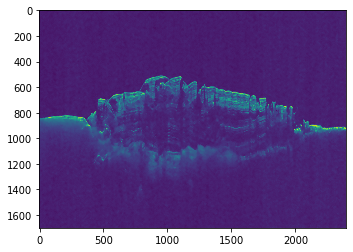

In [49]:
imshow(imgInTiny)

In [50]:
dilation_size = 5
element = cv.getStructuringElement( cv.MORPH_ELLIPSE,
                                       ( 2*dilation_size + 1, 2*dilation_size+1 ),
                                       ( dilation_size, dilation_size ) );

In [51]:
eroded = cv.erode(imgBin, element)
imgBin = cv.dilate(eroded, element)

In [52]:
#res = np.uint8(0.5*(imgIn + imgBin))
resSquare = np.uint8(0.5*(imgInSquare + imgBin))
edges = cv.Canny(imgIn,50,100) #2nd,3rd: lower and upper threshold

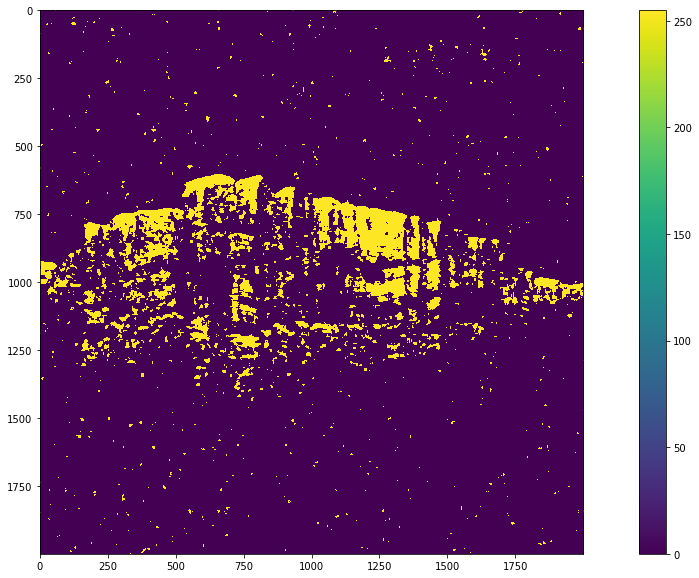

In [55]:
figure(figsize=(20,10))

imshow(ori_bin)
colorbar()

In [8]:
import scipy
from scipy import sparse

concomp = scipy.sparse.csgraph.connected_components(imgBin)
n_components, labels = concomp
somma = labels.min()
print(n_components)
np.mean(labels)

103


2.6265

349


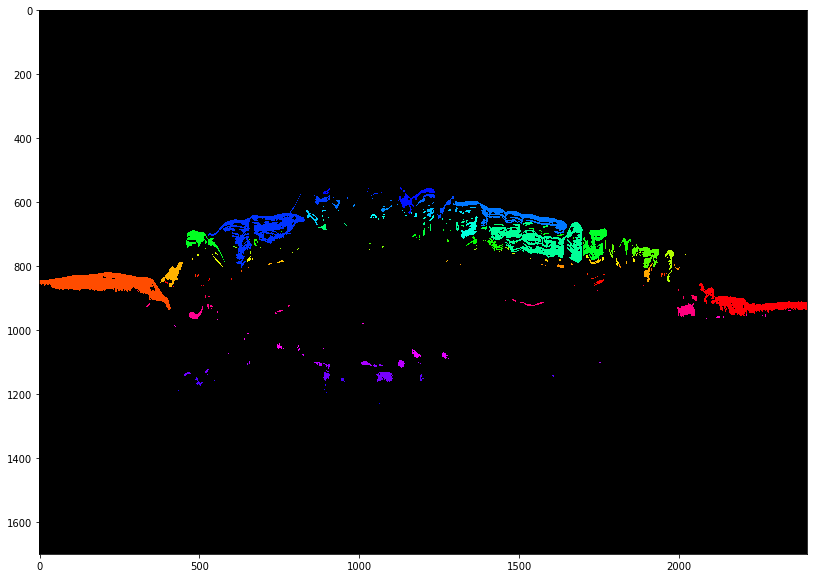

In [37]:
img = cv.threshold(imgInTiny, 90, 255, cv.THRESH_BINARY)[1]  # ensure binary
#imshow(img)
num_labels, labels_im = cv.connectedComponents(img)
print(num_labels)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels)) #each label gets a different hue
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch]) #each element of the output array will be a concatenation of the elements of the input arrays

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

    #cv.imshow('labeled.png', labeled_img)
    #cv.waitKey()

figure(figsize=(20,10))
a = imshow_components(labels_im)
imshow(a)

In [46]:
def connected_components(img, thr):
    img = cv.threshold(img, thr, 255, cv.THRESH_BINARY)[1]  # ensure binary
    num_labels, labels = cv.connectedComponents(img)
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    #print (blank_ch)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    figure(figsize=(20,10))
    imshow(labeled_img)

interact(connected_components, img=fixed(imgInTiny), thr=(0,255))

interactive(children=(IntSlider(value=127, description='thr', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.connected_components(img, thr)>

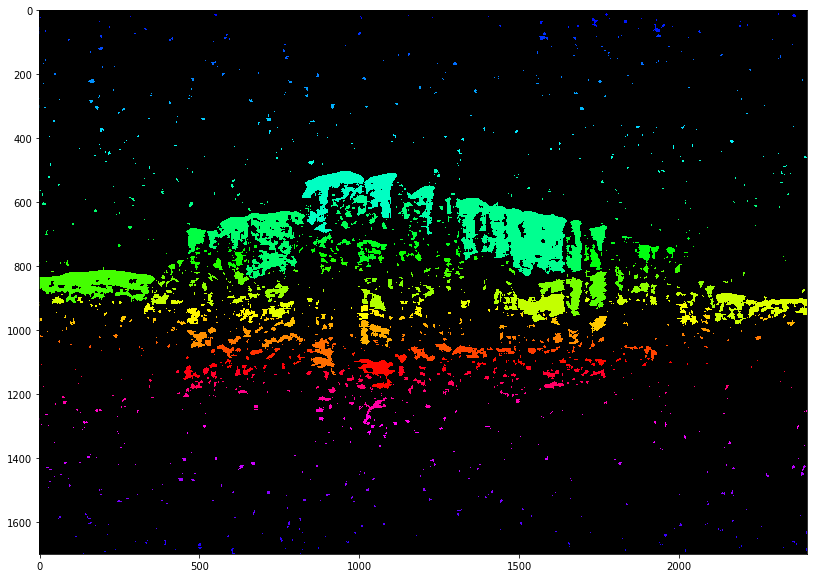

In [60]:
def connected_components_for_binaryimg(img):
    num_labels, labels = cv.connectedComponents(img)
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    #print (blank_ch)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    figure(figsize=(20,10))
    imshow(labeled_img)


connected_components_for_binaryimg(ori_bin)    